In [2]:
pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.5 MB/s eta 0:00:00:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Nov-2022/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

## Reading data-files
submission = pd.read_parquet(file_content_stream_1)
df = pd.read_parquet('s3://analytics-data-science-competitions/Tabular-Playground-Series/Tabular-Playground-Nov-2022/preds_concat_gzip.parquet', engine = 'fastparquet')

In [6]:
preds_df = df.clip(0, 1) ## Notice that some of the model prediction files have negative likehookds and greater than 1 likelihoods
train = preds_df[preds_df['target'].notnull()]
test = preds_df[preds_df['target'].isnull()] 

In [10]:
from sklearn.metrics import log_loss

train_new = train.copy()
logloss = list()

for i in range(0, 5000):
    
    logloss.append(log_loss(train_new['target'], train_new.iloc[:, i]))
    
#  Log-Loss dataframe
logloss_data = pd.DataFrame({'File': train_new.columns[:-1], 'LogLoss': logloss})
logloss_data = logloss_data.sort_values(by = 'LogLoss').reset_index(drop = True)
logloss_data.head(20)

,File,LogLoss
0,0.6222863195.csv,0.622286
1,0.6223807245.csv,0.622381
2,0.6225426578.csv,0.622543
3,0.6247722291.csv,0.624772
4,0.6253455681.csv,0.625346
5,0.6254850917.csv,0.625485
6,0.6255093621.csv,0.625509
7,0.6260141578.csv,0.626014
8,0.6263493693.csv,0.626349
9,0.6272779211.csv,0.627278


In [17]:
logloss_data.to_csv('logloss_data.csv', index = False)

In [13]:
X = train[logloss_data['File'][0:100].values]
Y = train['target']

test_new = test[logloss_data['File'][0:100].values]

## Defining list to store results
logit_results, test_preds_logit = list(), list()

fold = 1
kfold = StratifiedKFold(n_splits = 5, shuffle = True)
        
for train_ix, test_ix in kfold.split(X, Y):
    
    ## Splitting the data 
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    ## Building model
    logit_md = LogisticRegression(solver = 'liblinear', penalty = 'l1').fit(X_train, Y_train)
        
    ## Predicting on test
    logit_pred = logit_md.predict_proba(X_test)[:, 1]
    score = log_loss(Y_test, logit_pred)
    logit_results.append(score)
        
    print('Fold ', str(fold), ' result is:', score, '\n')

    test_preds_logit.append(logit_md.predict_proba(test_new)[:, 1])
    fold +=1

print('The average log-loss over 5-fold CV is', np.mean(logit_results))

Fold  1  result is: 0.5310085332338175 

Fold  2  result is: 0.5371195951983304 

Fold  3  result is: 0.5318544121508715 

Fold  4  result is: 0.5257264512172775 

Fold  5  result is: 0.5344636708896188 

The average log-loss over 5-fold CV is 0.532034532537983


In [14]:
test_preds_logit = pd.DataFrame(test_preds_logit)
print(test_preds_logit.shape)

test_preds_logit = test_preds_logit.mean(axis = 0)
print(test_preds_logit.head(5))

(5, 20000)
0    0.615394
1    0.695442
2    0.169539
3    0.425722
4    0.025819
dtype: float64


In [ ]:
submission['pred'] = test_preds_logit
submission.head()

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

logistic_performance = pd.DataFrame({'Number_of_Features': [100, 200, 300, 400, 500], 'CV_score': [0.5314294293449413, 0.5303333592114292, 0.5306822864009136, 0.5301723355083536, 0.5306497920414268], 'LB_score': [0.52438, 0.5239, 0.52357, 0.52319, 0.52313]})
logistic_performance['CV_score'] = round(logistic_performance['CV_score'], 5)
logistic_performance

,Number_of_Features,CV_score,LB_score
0,100,0.53143,0.52438
1,200,0.53033,0.52390
2,300,0.53068,0.52357
3,400,0.53017,0.52319
4,500,0.53065,0.52313


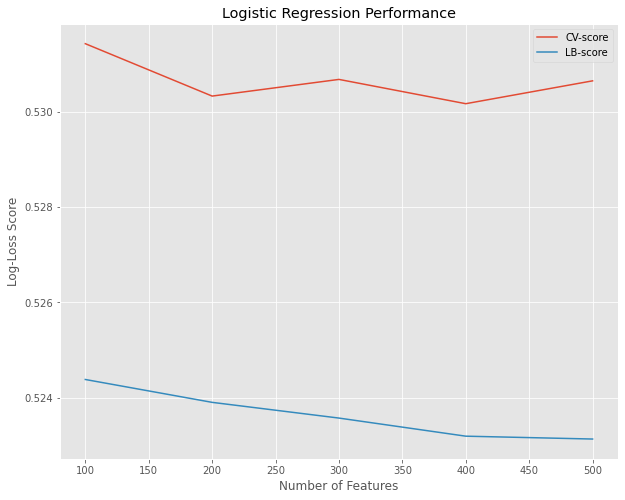

In [21]:
plt.figure(figsize = (10, 8))

sns.lineplot(data = logistic_performance, x = 'Number_of_Features', y = 'CV_score', label = 'CV-score').set(xlabel = 'Number of Features', ylabel = 'Log-Loss Score', title = 'Logistic Regression Performance')
sns.lineplot(data = logistic_performance, x = 'Number_of_Features', y = 'LB_score', label = 'LB-score')

plt.savefig('logistic_performace.png')
plt.show();

<AxesSubplot:>

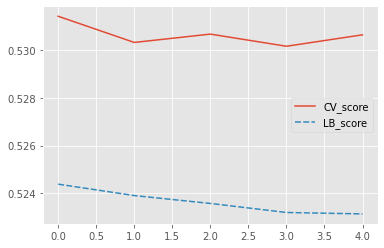

In [13]:
sns.lineplot(data = logistic_performance.drop(columns = 'Number_of_Features', axis = 1))